In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf
import datetime

import warnings
warnings.filterwarnings("ignore")

import RECH_functions as RECH

import pickle

In [2]:
act_func = RECH.relu

## Brownless et al 2011: As much data as possible
-> Data dates back to 1990

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'S&P 500 log returns')

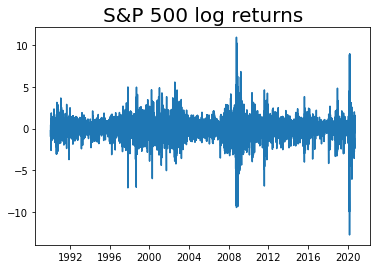

In [3]:
data = yf.download("^GSPC", start="1990-01-01", end="2020-10-01")
data['pct_change'] = data["Adj Close"].pct_change()
data['log_ret'] = np.log(data["Adj Close"]) - np.log(data["Adj Close"].shift(1))
data['log_ret * 100'] = data['log_ret'] * 100
returns = data['log_ret * 100'].values[1:]
plt.plot(data['log_ret * 100'])
plt.title("S&P 500 log returns", size = 20)

## What is sample, what is out of sample?

Important to have both low and high volatility periods both in the sample and outside the sample

Out of sample period: 2015- 2020

In [9]:
# in sample data is all the data before 01.01.2015
is_list = [(data.index[x] < datetime.date(2015, 1, 1)) for x in range(len(data)) ]
is_data = data[is_list]
is_data.drop(index=is_data.index[0], axis=0, inplace=True) # dropping the first value with NA in returns
is_returns = is_data['log_ret * 100'].values

# out of sample data is all the data from 01.01.2015
os_list = [(data.index[x] >= datetime.date(2015, 1, 1)) for x in range(len(data)) ]
os_data = data[os_list]
os_returns = os_data['log_ret * 100'].values

In [10]:
len(os_data)

1447

In [11]:
len(is_data)

6300

In [13]:
#is_data

## Estimating GARCH

No updating

In [14]:
vP0 = (0.1, 0.1, 0.8)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 1))

res_garch = opt.minimize(RECH.garch_loglike, vP0, args = (act_func, is_returns),
                  bounds = my_bounds,
                   method = "Nelder-Mead",
                  options = {"disp": True, "maxiter": 500000})

Optimization terminated successfully.
         Current function value: 5364.301201
         Iterations: 79
         Function evaluations: 144


In [20]:
res_garch.x

array([0.01091141, 0.0762411 , 0.91491172])

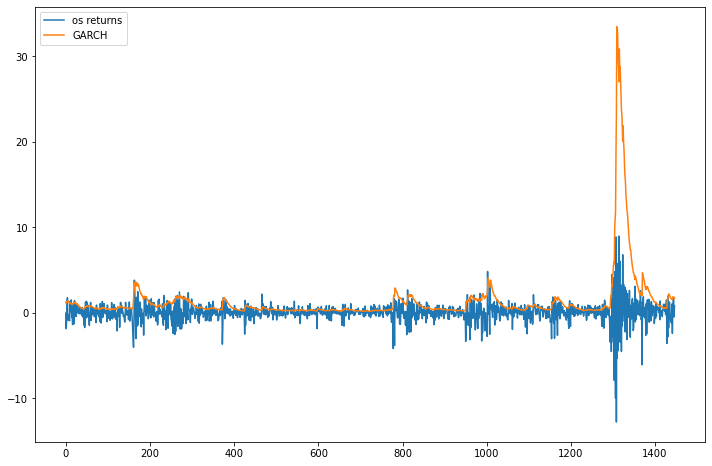

In [21]:
fig, axs = plt.subplots(1,1, figsize = (12,8))
plt.plot(os_returns, label = "os returns")
plt.plot(RECH.garch(res_garch.x, act_func, os_returns)[0], label = "GARCH")
plt.legend()

In [236]:
# for period forecasts

def garch_forecast_2(pars, y_start, sigma_start, length):
    fore = np.zeros(length)
    for i in range(length):
        if i == 0:
            fore[i] = pars[0] + pars[1] * y_start**2 + pars[2] * sigma_start
        else:
            fore[i] = pars[0] + pars[2] * fore[i-1]
    return fore

In [22]:
def garch_forecast(pars, y_start, sigma_start, returns):
    fore = np.zeros(len(returns))
    for i in range(len(returns)):
        if i == 0:
            fore[i] = pars[0] + pars[1] * y_start**2 + pars[2] * sigma_start
        else:
            fore[i] = pars[0] + pars[1] * returns[i-1]**2 + pars[2] * fore[i-1]
    return fore

## Re-estimating GARCH for parameter updates
weekly, every 5 days

In [23]:
vP0 = (0.1, 0.1, 0.8)
my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 1))

update_window = 20 # length of the updating window 20 -> monthly, 5 -> weekly
sample_returns = is_returns # the sample returns serires keeps getting longer: after each iteration new informatuion is added
os_decreasing = os_returns # out of sample returns, shrinking as sample increases
forecasts = np.array(()) # empty array to be filles with forecasts
res_list = [] # results, jsut to check if it actually updates

for i in range(int(len(os_returns)/update_window)):
    if i == 0:
        # different starting values for optimisation as well as for forecasting in the first iteration
        res_garch = opt.minimize(RECH.garch_loglike, vP0, args = (act_func, sample_returns),
                      bounds = my_bounds,
                       method = "Nelder-Mead",
                      options = {"disp": False, "maxiter": 500000})
        this_five_forecast = garch_forecast(res_garch.x, sample_returns[-1], res_garch.x[0]/(1-res_garch.x[1]-res_garch.x[2]), os_decreasing[:update_window])
        sample_returns = np.concatenate((sample_returns, os_decreasing[:update_window]))
        os_decreasing = np.delete(os_decreasing,range(update_window))
        forecasts = np.concatenate((forecasts, this_five_forecast))
        res_list.append(res_garch.x)
    else:
        res_garch = opt.minimize(RECH.garch_loglike, res_garch.x, args = (act_func, sample_returns),
                      bounds = my_bounds,
                       method = "Nelder-Mead",
                      options = {"disp": False, "maxiter": 500000})
        this_five_forecast = garch_forecast(res_garch.x, sample_returns[-1], forecasts[-1], os_decreasing[:update_window])
        sample_returns = np.concatenate((sample_returns, os_decreasing[:update_window]))
        os_decreasing = np.delete(os_decreasing,range(update_window))
        forecasts = np.concatenate((forecasts, this_five_forecast))
        res_list.append(res_garch.x)

In [238]:
res_garch.x

array([0.01710683, 0.10143322, 0.88447166])

In [239]:
res_list[-1]

array([0.01710683, 0.10143322, 0.88447166])

## Realised Volatility

Evaluating forecasts using realised volatility as a proxy for the true volatility

In [185]:
rv = pd.read_csv("data/daily_rv_SP500.csv")

In [186]:
rv_list  = []

for i in range(len(rv)):
    rv_list.append(datetime.date(int(rv["date"][i][0:4]),int(rv["date"][i][5:7]), int(rv["date"][i][8:10])))

rv["Datetime"] = rv_list

In [187]:
#rv[rv["Datetime"] <= os_data.index[-1]]

#rv[rv["Datetime"] >= os_data.index[0]]

rv_true = rv[(rv["Datetime"] <= os_data.index[-1]) & (rv["Datetime"] >= os_data.index[0])]

rv_true.reset_index(inplace = True)

rv_true.drop(rv_true.tail(len(os_returns) - len(forecasts)).index,inplace=True)

rv_true["forecasts"] = forecasts

rv_true["RV * 10000"] = rv_true["RV"] * 10000

rv_true["log ret"] = os_returns[:-7]

rv_true.drop("index", axis = 1, inplace = True)

In [188]:
rv_true.set_index("Datetime", inplace = True)

## This data frame contains all out-of-sample data: volatility proxy RV; model forecasts; s&p log returns

In [191]:
rv_true

,date,RV,forecasts,RV * 10000,log ret
Datetime,,,,,
2015-01-02,2015-01-02,0.000071,1.221190,0.708029,-0.034002
2015-01-05,2015-01-05,0.000077,1.128280,0.766579,-1.844721
2015-01-06,2015-01-06,0.000112,1.302637,1.115356,-0.893325
2015-01-07,2015-01-07,0.000080,1.263552,0.800060,1.156274
2015-01-08,2015-01-08,0.000066,1.268882,0.660349,1.773017
...,...,...,...,...,...
2020-09-15,2020-09-15,0.000105,2.219370,1.052227,0.520579
2020-09-16,2020-09-16,0.000077,2.007566,0.774933,-0.462965
2020-09-17,2020-09-17,0.000370,1.814483,3.704069,-0.844795


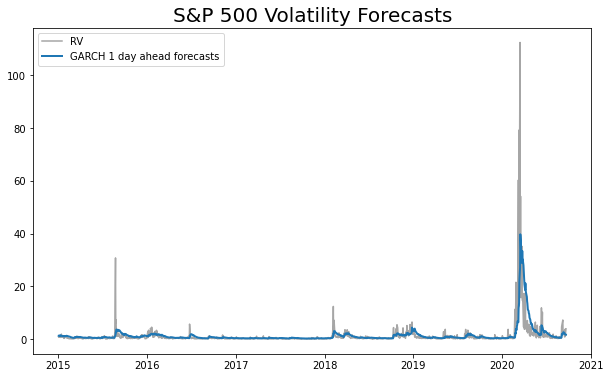

In [284]:
fig, axs = plt.subplots(1,1, figsize = (10,6))
plt.plot(rv_true["RV * 10000"], alpha = 0.7, label = "RV", color = "grey")
plt.plot(rv_true["forecasts"], label = "GARCH 1 day ahead forecasts", linewidth = 2)
plt.title("S&P 500 Volatility Forecasts", size = 20)
plt.legend()

## Forecast Evaluation

quasi-likelihood loss (QL) is the favourite metric of Brownless et al

QL loss function is defined as: 

\begin{align*}
QL: \quad L_{QL}(\hat \sigma_t^2, h_{t|t-k}) = \frac{\hat \sigma_t^2}{h_{t|t-k}} - log \frac{\hat \sigma_t^2}{h_{t|t-k}} - 1
\end{align*}


Alternatively there is MSE:

\begin{align*}
MSE: \quad L_{MSE}(\hat \sigma_t^2, h_{t|t-k}) = (\hat \sigma_t^2 - h_{t|t-k})^2
\end{align*}

In [197]:
def ql_loss(sigma_series, h_series):
    return np.mean( (sigma_series/h_series) - np.log(sigma_series/h_series) -1 )

In [199]:
def mse(sigma_series, h_series):
    return np.mean( (sigma_series - h_series)**2 )

In [198]:
ql_loss(rv_true["RV * 10000"], rv_true["forecasts"])

0.3923067505617931

In [200]:
mse(rv_true["RV * 10000"], rv_true["forecasts"])

15.894287585905168

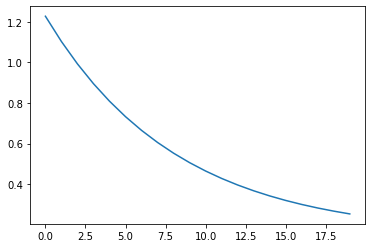

In [237]:
# multi day forecast

my_test = garch_forecast_2(res_garch.x, sample_returns[-1], res_garch.x[0]/(1-res_garch.x[1]-res_garch.x[2]), 20)

res_garch.x

my_test[-1]

0.01710683 + 0.88447166 * my_test[-1]

my_test

plt.plot(my_test)